<center><h1>Face markdown</h1></center>

We have images with faces and the coordinates of keypoints on them. The task is to mark new images in the same way.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 12
np.random.seed(SEED)
%matplotlib inline

Load the data.

In [4]:
data = pd.read_csv('train.csv')
data.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55


`filename` consists only of the file name. Expand it to the full path.

In [2]:
TRAIN_PATH = 'train'
TEST_PATH = 'test/test'

In [5]:
data['filename'] = data['filename'].apply(lambda x: os.path.join(TRAIN_PATH, x))
data.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,train\05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,train\04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,train\05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,train\03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,train\00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55


Add a function for viewing images with dots.

In [9]:
def visualize_points(img, points, radius=2, color=(255, 0, 0)):
    """
    Add points to the image.

    Parameters
    ----------
    image : array_like
        ndarray with image;
    points : iterable
        list with points coordinates [(x, y), ...];
    radius : int, optional
        points radius;
    color : iterable, optional
        typle with (R, G, B) color code.
    
    Rerutns
    -------
    img : ndarray
        image ndarray with points.
    """
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), radius, color=color, thickness=-1)
    return img

In [8]:
def show_image(image, points):
    """
    Show image with given points.

    Parameters
    ----------
    image : array_like
        array with image;
    points : iterable
        list with points coordinates [(x, y), ...].
    """
    image = visualize_points(image.copy(), points, int(image.shape[0]*0.01))
    f = plt.figure(figsize=(18, 12))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()

To augment and resize an image, we can use the albumentations library. It allows to transform key points on the image simultaneously with the image. The points in this library are represented as [(x, y), (x, y)], so let's add a function to convert the list of points into a list of coordinates pairs.

In [7]:
def points_to_list(points):
    '''
    Transform coordinates list into coordinates pairs list.

    [x1, y1, x2, y2, ...] -> [(x1, y1), (x2, y2), ...].
    
    Parameters
    ----------
    points : iterable
        list with coordinates.
    
    Returns
    -------
    points_list : list
        list with coordinates pairs.
    '''
    points_list = []
    for i in range(0, len(points), 2):
        points_list.append((
            points[i],
            points[i+1]
        ))
    return points_list

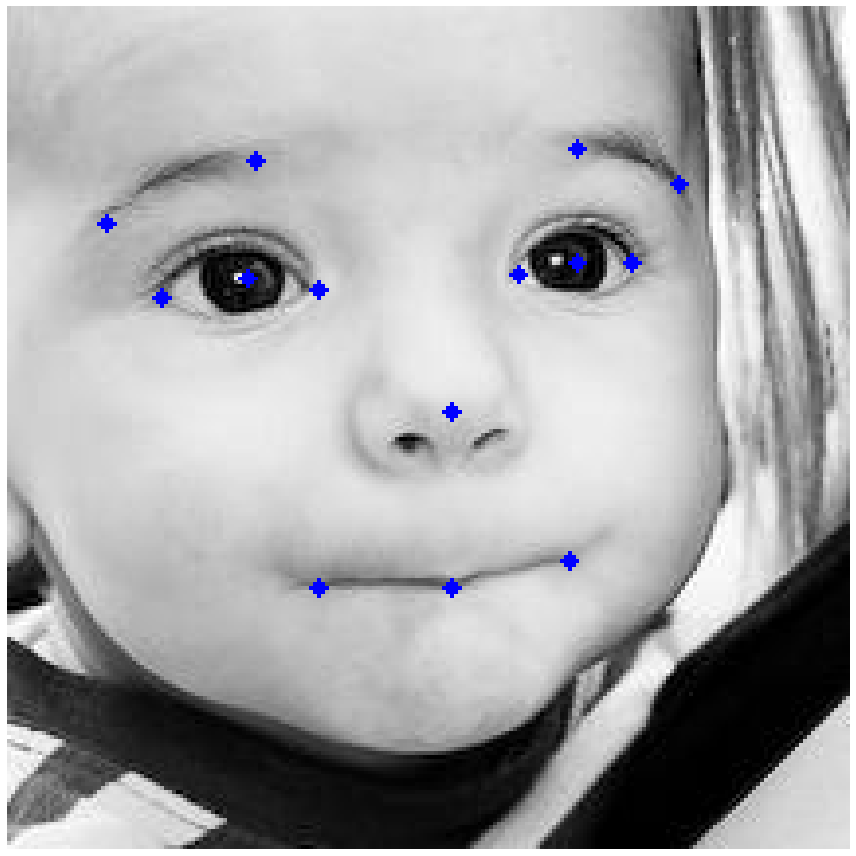

In [15]:
image = cv2.imread(data['filename'][0])
points = points_to_list(data.iloc[0, 1:])
show_image(image, points)

The available images have different sizes but model takes a matrix of a certain size as input. Therefore, it is necessary to convert all images to a same size. Let's take 128x128 for a start. A larger size may improve the quality of predictions, but it will increase the training time and model runtime.

In [11]:
IMAGE_SIZE = 128

In [ ]:
# set coordinates as [(x, y), (x, y), ...]
kpoint_params = A.KeypointParams(
    format='xy'
)

In [12]:
aug = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, always_apply=True),
], keypoint_params=kpoint_params)

In [13]:
def show_augmented(image, augmentation, points):
    '''
    Show image with applyed augmentations.

    Parameters
    ----------
    image : array_like
        array with image;
    augmentation : Compose
        Compose object with image augmentations;
    points : iterable
        list with coordinates pairs.
    '''
    augmented = augmentation(image=image, keypoints=points)
    show_image(augmented['image'], augmented['keypoints'])

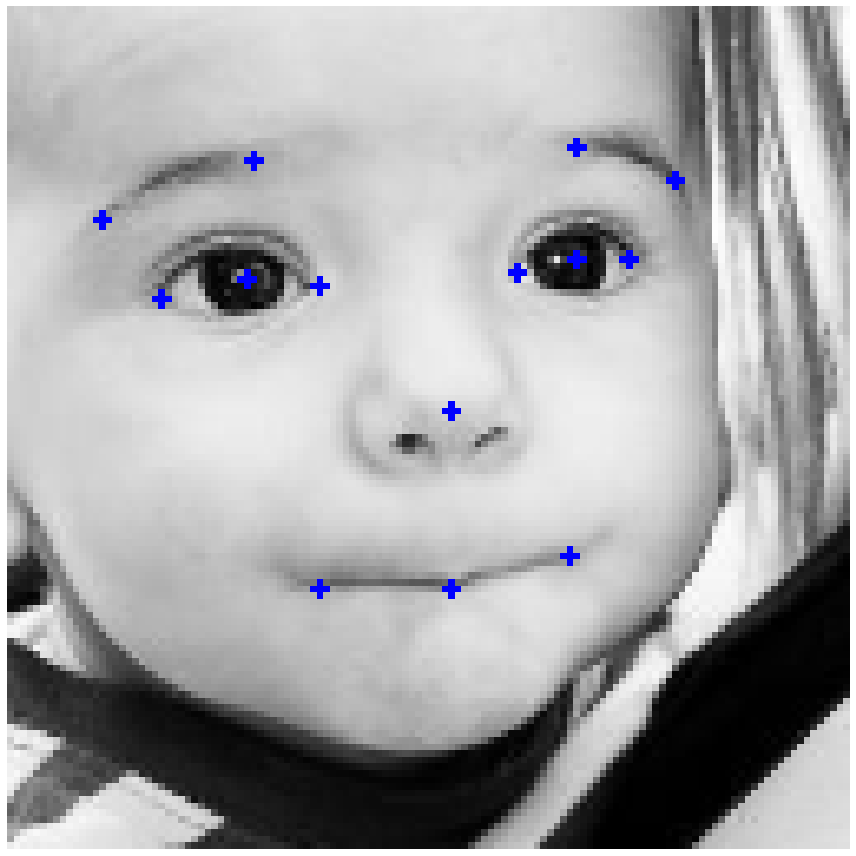

In [16]:
show_augmented(image, aug, points)

The image has become smaller, but the positions of the points are still in place.

We have 5000 items for training. This may be enough but it is better to increase images number. Let's use image augmentation and generate distorted versions of the existing images. Also, the coordinates of the points should be scaled to the interval [-1, 1]. This will allow to unbind coordinates from images size.

In [ ]:
def images_aug(img_path, size, keypoints, save_path, aug=None, num=3):
    '''
    Create and save augmented images.
    
    New images are saved in `save_path`/images. DataFrame with images information is
    saved in `save_path`.

    Parameters
    ----------
    img_path : iterable
        list with images paths;
    size : int
        target image size;
    keypoints : iterable
        list with points coordinates;
    save_path : str
        save directory path;
    aug : Compose, optional
        Compose object with images augmentations;
    num : int
        number of augmented images per image.

    Rerurns
    -------
    DataFrame
        DataFrame with file path and points coordinates.
    '''
    # create save directory if needed
    os.makedirs(save_path, exist_ok=True)
    
    kpoint_params = A.KeypointParams(
        format='xy'
    )
    aug_resize = A.Compose([
        A.Resize(size, size, always_apply=True),
    ], keypoint_params=kpoint_params)

    rows = []
    for path, points in tqdm(zip(img_path, keypoints), desc='Augmenteting images'):
        image = cv2.imread(path)
        points = points_to_list(points)
        image = aug_resize(image=image, keypoints=points)
        # scale coordinates to [-1, 1]
        points = (np.array(image['keypoints']).flatten() - size/2)/(size/2)
        points = points.tolist()
        file_name = os.path.basename(path)
        # construct DataFrame row with resized file path and points
        row = [file_name]
        row.extend(points)
        rows.append(row)
        # save image
        cv2.imwrite(os.path.join(save_path, file_name), image['image'])
        # apply augmentation if needed
        if aug:
            for i in range(num):
                augmented = aug(image=image['image'], keypoints=image['keypoints'])
                # add image if all points after augmentations are the same
                if len(augmented['keypoints']) == len(image['keypoints']):
                    points = (np.array(augmented['keypoints']).flatten() - size/2)/(size/2)
                    points = points.tolist()
                    file_name = os.path.basename(path)
                    file_name = file_name.split('.')[0]
                    file_name = f'{file_name}_{i}.jpg'
                    row = [file_name]
                    row.extend(points)
                    rows.append(row)
                    cv2.imwrite(os.path.join(save_path, file_name), augmented['image'])
    
    # add columns names
    columns = ['filename']
    for i in range(1, len(image['keypoints'])+1):
        columns.append(f'x{i}')
        columns.append(f'y{i}')
    
    rows = pd.DataFrame(rows, columns=columns)
    rows.to_csv('annotations.csv', index=None)
    
    return rows

I'll use rotations and reflections as augmentations to get faces at different angles.

In [ ]:
aug = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.Rotate(limit=45, p=0.8),
    A.RandomRotate90(p=0.25),
], keypoint_params=kpoint_params)

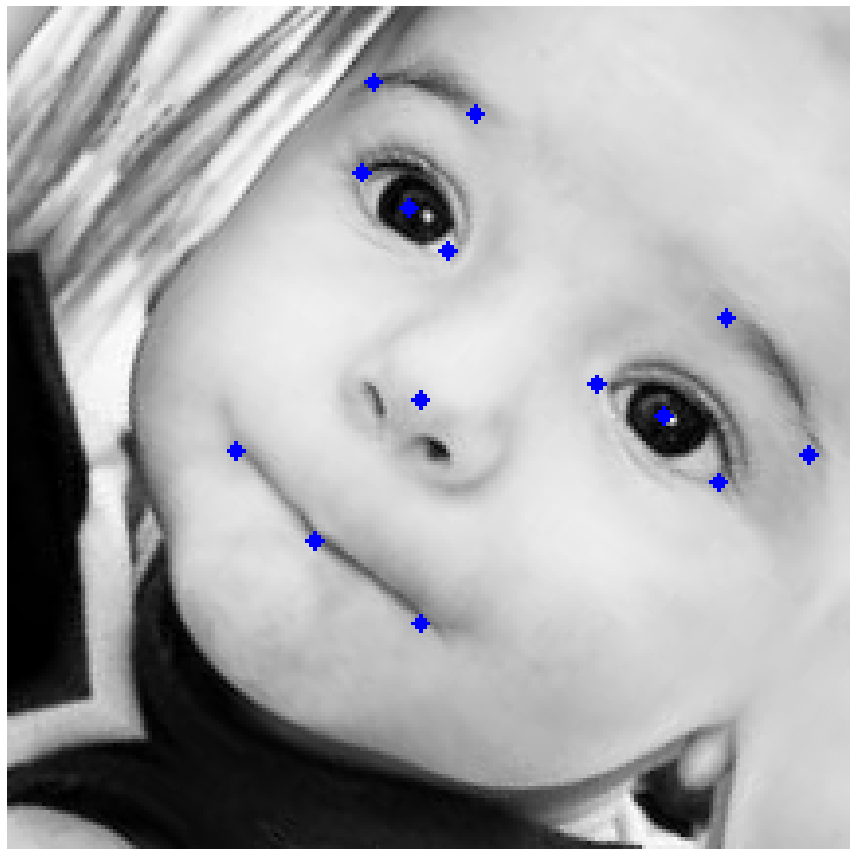

In [ ]:
show_augmented(image, aug, points)

In [17]:
SAVE_PATH = 'images'

In [ ]:
data_df = images_aug(data['filename'], 128, data.drop('filename', axis=1).values, SAVE_PATH, aug, 5)

Augmenteting images: 5000it [04:05, 20.39it/s]


In [19]:
data_df.head()

,filename,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13
0,05317.jpg,-0.767442,-0.488372,-0.413953,-0.637209,0.348837,-0.665116,0.590698,-0.581395,-0.637209,-0.311628,-0.432558,-0.358140,-0.265116,-0.330233,0.209302,-0.367442,0.348837,-0.395349,0.479070,-0.395349,0.051163,-0.041860,-0.265116,0.376744,0.051163,0.376744,0.330233,0.311628
1,05317_0.jpg,0.751817,-0.488372,0.398328,-0.637209,-0.364462,-0.665116,-0.606323,-0.581395,0.621584,-0.311628,0.416933,-0.358140,0.249491,-0.330233,-0.224927,-0.367442,-0.364462,-0.395349,-0.494695,-0.395349,-0.066788,-0.041860,0.249491,0.376744,-0.066788,0.376744,-0.345858,0.311628
2,05317_1.jpg,0.885907,0.088307,0.701665,-0.248088,0.121699,-0.744341,-0.119764,-0.829201,0.674004,0.145716,0.542673,-0.017984,0.394197,-0.100268,0.045833,-0.424459,-0.046077,-0.533093,-0.148059,-0.614088,-0.032819,-0.071153,-0.045490,0.453348,-0.293161,0.256646,-0.471196,0.032094
3,05317_2.jpg,0.890464,-0.040581,0.659977,-0.347146,0.014963,-0.755294,-0.236159,-0.804725,0.688957,0.046562,0.535551,-0.096658,0.376829,-0.156847,-0.014344,-0.427848,-0.120855,-0.522210,-0.233378,-0.587777,-0.041626,-0.066922,0.020893,0.453994,-0.252378,0.294760,-0.460715,0.097997
4,04767.jpg,-0.696429,-0.428571,-0.303571,-0.517857,0.000000,-0.607143,0.446429,-0.714286,-0.642857,-0.303571,-0.428571,-0.303571,-0.232143,-0.267857,0.178571,-0.410714,0.303571,-0.482143,0.535714,-0.500000,0.000000,0.178571,-0.196429,0.428571,0.053571,0.428571,0.321429,0.357143


Split the data into training and test sets. There are about 20,000 data and 0.2 part of them is sufficient for testing.

In [ ]:
train_df, test_df = train_test_split(data_df, train_size=.8, random_state=12)

Image data usually take up a lot of space and it is impossible to load them all into memory, so we will use a data generator. It will load the necessary data as training progresses. We will also set aside 0.2 of the training sample as a validation sample to evaluate the model during training.

In [ ]:
datagen = ImageDataGenerator(
    validation_split=.2,
    rescale=1./255
)

Create a separate generator for each set.

In [50]:
train_datagen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=SAVE_PATH,
    x_col="filename",
    y_col=train_df.columns.drop('filename'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='raw',
    color_mode = "grayscale",
    batch_size=64,
    subset='training'
)

valid_datagen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=SAVE_PATH,
    x_col="filename",
    y_col=train_df.columns.drop('filename'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='raw',
    color_mode = "grayscale",
    batch_size=64,
    subset='validation'
)

test_datagen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=SAVE_PATH,
    x_col="filename",
    y_col=train_df.columns.drop('filename'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='raw',
    color_mode = "grayscale",
    batch_size=64,
)

Found 12748 validated image filenames.
Found 3187 validated image filenames.


Let's also create a generator for unlabeled images. For this data, there is no reason to create a DataFrame with their description (there will be only the file names). Instead, the generator will load all images from the specified folder.

In [9]:
predict_datagen = datagen.flow_from_directory(
    TEST_PATH,
    (IMAGE_SIZE, IMAGE_SIZE),
    'grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=1
)

Found 1001 images belonging to 1 classes.


# Models

Now we can start to train models. Usually convolutional networks are used to work with image data. A fully connected network can also be used, but it will have a large number of parameters to train.

Define some utility functions.

In [18]:
MODELS_PATH = 'models'

In [ ]:
def plot_loss(hist):
    """
    Plot model train and validation losses.
    """
    loss = hist['loss']
    val_loss = hist['val_loss']        
    plt.plot(loss, "--", linewidth=3, label="train")
    plt.plot(val_loss, linewidth=3, label="val")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

In [ ]:
def show_image_predicted(image_data, model, path):
    """
    Show image with predicted(green) and target(blue) points.

    Parameters
    ----------
    image_data : Series
        pandas Series with filename and points coordinates;
    model : Model
        keras model;
    path : str
        path to image file.
    """
    # read image
    filename = os.path.join(path, image_data['filename'])
    image = cv2.imread(filename)
    # convert image to gray
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = image_gray[np.newaxis, ..., np.newaxis]/255
    # transform target points coordinates back to initial
    true_points = image_data.drop('filename').values
    true_points = (true_points*IMAGE_SIZE/2 + IMAGE_SIZE/2).astype(np.uint8)
    true_points = points_to_list(true_points)
    # transform predicted points coordinates back to initial
    predicted = model.predict(image_gray)[0]
    predicted = (predicted*IMAGE_SIZE/2 + IMAGE_SIZE/2).astype(np.uint8)
    predicted = points_to_list(predicted)
    # add points to image
    image = visualize_points(image, true_points, int(image.shape[0]*0.01), (255, 0, 0))
    image = visualize_points(image, predicted, int(image.shape[0]*0.01), (0, 255, 0))
    f = plt.figure(figsize=(18, 12))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()

At first let's build a simple network with convolutional and fully connected layers with 32 neurons.

In [178]:
model = Sequential()
model.add(Conv2D(
    64,
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(28))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 262144)            0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                8388640   
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 28)                924       
Total params: 8,390,204
Trainable params: 8,390,204
Non-trainable params: 0
___________________________________________

In [164]:
history = model.fit(train_datagen, 
                    epochs=50,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/50
199/199 [==============================] - 10s 51ms/step - loss: 0.3141 - val_loss: 0.1369
Epoch 2/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1360 - val_loss: 0.1197
Epoch 3/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1184 - val_loss: 0.1125
Epoch 4/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1131 - val_loss: 0.1097
Epoch 5/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1125 - val_loss: 0.1089
Epoch 6/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1125 - val_loss: 0.1085
Epoch 7/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1120 - val_loss: 0.1085
Epoch 8/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1121 - val_loss: 0.1084
Epoch 9/50
199/199 [==============================] - 10s 50ms/step - loss: 0.1121 - val_loss: 0.1086
Epoch 10/50
199/199 [==============================] - 10s 50ms/step - loss: 0.112

In [ ]:
model.save(os.path.join(MODELS_PATH, 'model_1cnn_1dense.h5'))

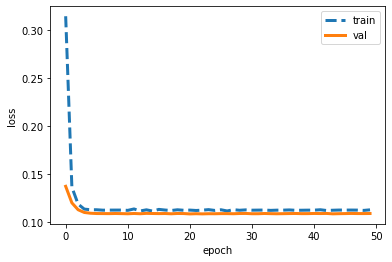

In [165]:
plot_loss(history.history)

The error drops quickly enough to 0.11 and then stops changing. Let's test the model on the test set.

In [166]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 2s 39ms/step - loss: 0.1122


0.11220339685678482

The result is not much different from the validation one. Let's look at the model results on the image.

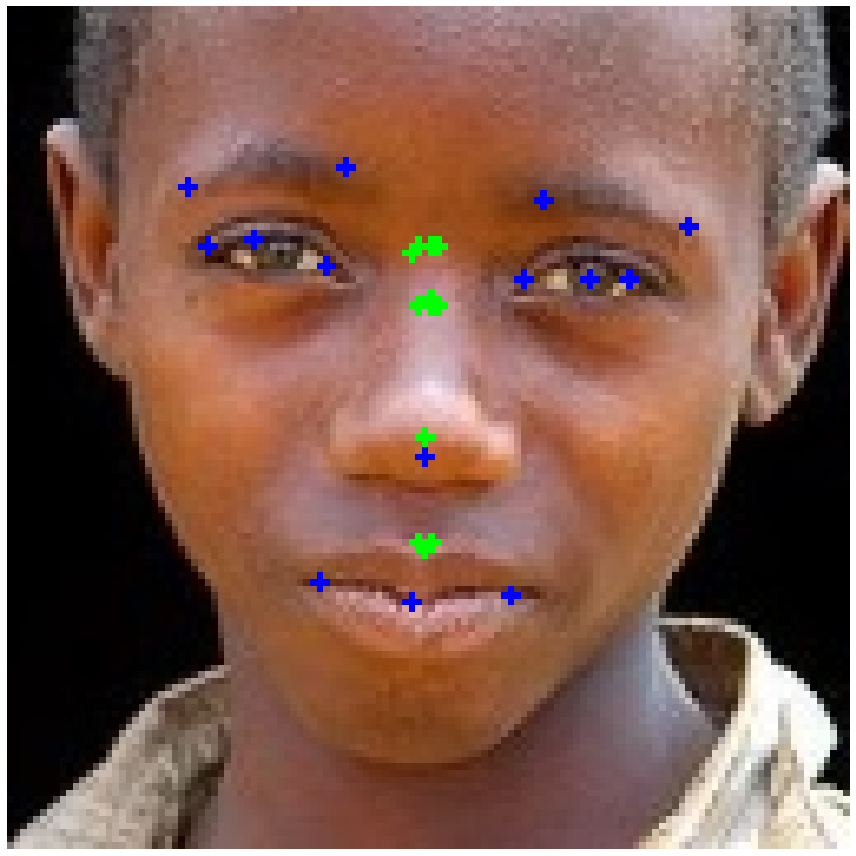

In [176]:
show_image_predicted(test_df.iloc[0], model, SAVE_PATH)

The points predicted by the model (green) are at completle wrong positions. The model is clearly not handling the data. Let's try to make the model more complicated. Let's add another convolutional layer and increase the number of neurons on a fully connected layer.

In [179]:
model = Sequential()
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(28))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)             

In [180]:
history = model.fit(train_datagen, 
                    epochs=50,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/50
199/199 [==============================] - 10s 51ms/step - loss: 0.1763 - val_loss: 0.0994
Epoch 2/50
199/199 [==============================] - 10s 51ms/step - loss: 0.1005 - val_loss: 0.0925
Epoch 3/50
199/199 [==============================] - 10s 51ms/step - loss: 0.0920 - val_loss: 0.0865
Epoch 4/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0857 - val_loss: 0.0811
Epoch 5/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0802 - val_loss: 0.0794
Epoch 6/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0757 - val_loss: 0.0784
Epoch 7/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0718 - val_loss: 0.0804
Epoch 8/50
199/199 [==============================] - 10s 50ms/step - loss: 0.0688 - val_loss: 0.0801
Epoch 9/50
199/199 [==============================] - 10s 51ms/step - loss: 0.0653 - val_loss: 0.0793
Epoch 10/50
199/199 [==============================] - 10s 50ms/step - loss: 0.062

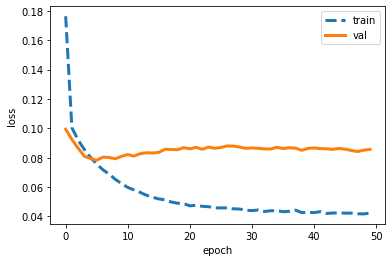

In [181]:
plot_loss(history.history)

The model also reaches the best result on the validation set pretty quick, but now the error on the test set continues to decrease. The model is already doing better, although it is starting to overfit.

In [182]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 2s 38ms/step - loss: 0.0871


0.08705415576696396

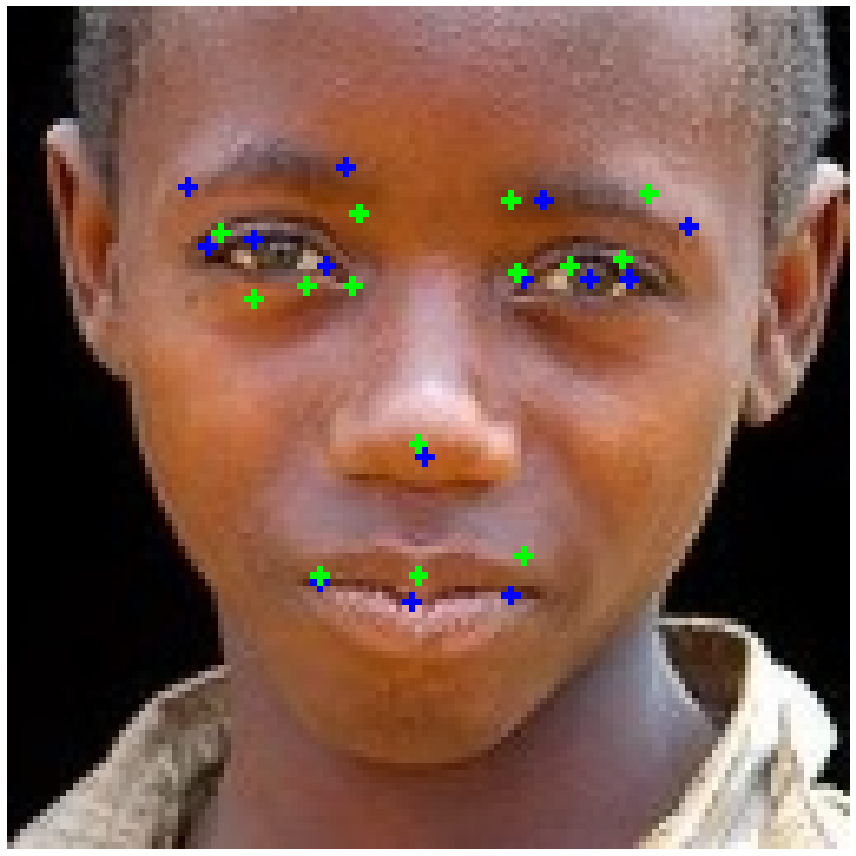

In [183]:
show_image_predicted(test_df.iloc[0], model, SAVE_PATH)

In [ ]:
model.save(os.path.join(MODELS_PATH, 'model_2cnn_1dense.h5'))

The predicted points are much closer to the true ones. Let's try to increase the number of layers further, but increase Dropuot.

In [189]:
model = Sequential()
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    128, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(28))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 32768)           

Since the model reached its minimum rather quickly, we will reduce the number of epochs.

In [190]:
history = model.fit(train_datagen, 
                    epochs=30,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/30
199/199 [==============================] - 10s 52ms/step - loss: 0.1125 - val_loss: 0.0857
Epoch 2/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0846 - val_loss: 0.0763
Epoch 3/30
199/199 [==============================] - 10s 52ms/step - loss: 0.0753 - val_loss: 0.0720
Epoch 4/30
199/199 [==============================] - 10s 52ms/step - loss: 0.0676 - val_loss: 0.0676
Epoch 5/30
199/199 [==============================] - 10s 52ms/step - loss: 0.0624 - val_loss: 0.0660
Epoch 6/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0577 - val_loss: 0.0666
Epoch 7/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0522 - val_loss: 0.0656
Epoch 8/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0472 - val_loss: 0.0664
Epoch 9/30
199/199 [==============================] - 10s 51ms/step - loss: 0.0411 - val_loss: 0.0674
Epoch 10/30
199/199 [==============================] - 10s 51ms/step - loss: 0.036

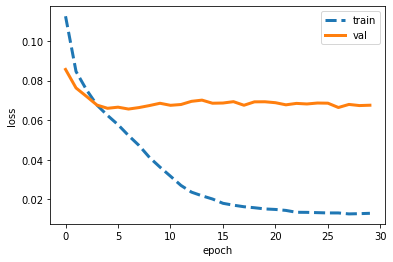

In [191]:
plot_loss(history.history)

In [192]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 2s 37ms/step - loss: 0.0687


0.06867071986198425

The model behaves the same way, but the error has been reduced. Let's take a look at the image.

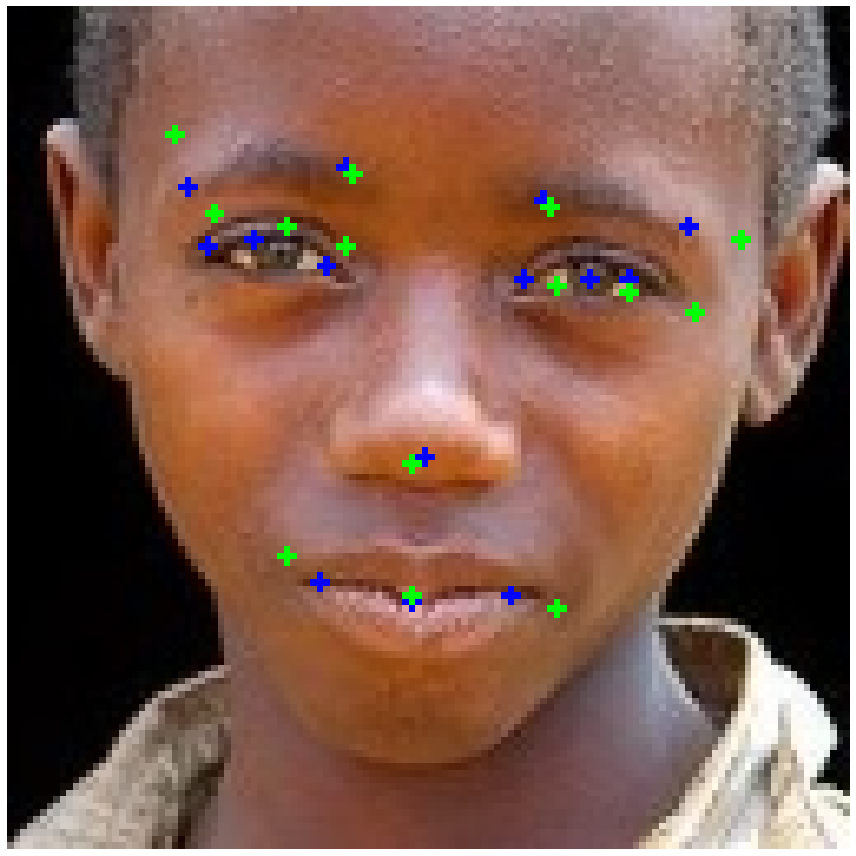

In [193]:
show_image_predicted(test_df.iloc[0], model, SAVE_PATH)

In [ ]:
model.save(os.path.join(MODELS_PATH, 'model_3cnn_1dense.h5'))

The dots are closer on the image. Let's add an additional full-connect layer. Also add a Dropout after each Conv2D to reduce overfitting.

In [199]:
model = Sequential()
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(
    128, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(28))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 32, 32, 128)     

In [200]:
history = model.fit(train_datagen, 
                    epochs=20,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/20
199/199 [==============================] - 10s 52ms/step - loss: 0.1193 - val_loss: 0.0890
Epoch 2/20
199/199 [==============================] - 10s 51ms/step - loss: 0.0826 - val_loss: 0.0733
Epoch 3/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0746 - val_loss: 0.0692
Epoch 4/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0687 - val_loss: 0.0674
Epoch 5/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0666 - val_loss: 0.0657
Epoch 6/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0631 - val_loss: 0.0643
Epoch 7/20
199/199 [==============================] - 10s 51ms/step - loss: 0.0599 - val_loss: 0.0632
Epoch 8/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0580 - val_loss: 0.0626
Epoch 9/20
199/199 [==============================] - 10s 52ms/step - loss: 0.0545 - val_loss: 0.0618
Epoch 10/20
199/199 [==============================] - 10s 51ms/step - loss: 0.052

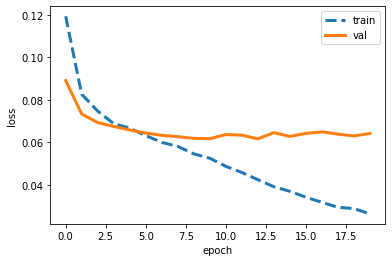

In [201]:
plot_loss(history.history)

In [202]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 2s 37ms/step - loss: 0.0657


0.06572848558425903

In [ ]:
model.save(os.path.join(MODELS_PATH, 'model_3cnn_2dense.h5'))

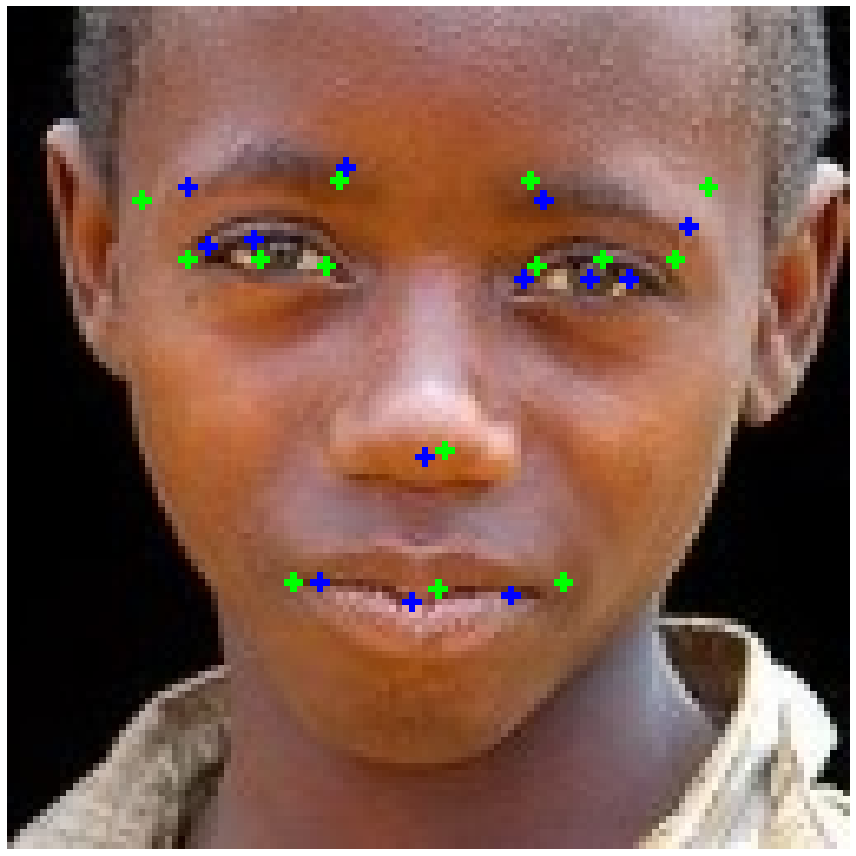

In [204]:
show_image_predicted(test_df.iloc[0], model, SAVE_PATH)

The result on the validation subset did not change, but on the training subset the error is decreasing slower. Most likely, further increase in the number of layers will not lead to significant improvements in the model quality, but let's try to make sure. Let's make two Conv2D layers with MaxPooling2D after each pair. In theory, more layers should be able to capture more complex patterns in the data.

In [149]:
model = Sequential()
model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    32, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    64, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    128, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    128, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    256, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    256, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(
    512, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())

model.add(Conv2D(
    512, 
    kernel_size=(3, 3), 
    activation='relu',
    padding='same'
))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten)

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(28))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization_30 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_32 (Batc (None, 64, 64, 64)      

In [150]:
history = model.fit(train_datagen, 
                    epochs=50,
                    steps_per_epoch = train_datagen.samples // 64,
                    validation_data = valid_datagen, 
                    validation_steps = valid_datagen.samples // 64
                    )

Epoch 1/50
199/199 [==============================] - 15s 77ms/step - loss: 0.4540 - val_loss: 0.1144
Epoch 2/50
199/199 [==============================] - 15s 77ms/step - loss: 0.1116 - val_loss: 0.1174
Epoch 3/50
199/199 [==============================] - 15s 76ms/step - loss: 0.1014 - val_loss: 0.1088
Epoch 4/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0955 - val_loss: 0.0968
Epoch 5/50
199/199 [==============================] - 15s 76ms/step - loss: 0.0876 - val_loss: 0.0878
Epoch 6/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0801 - val_loss: 0.0792
Epoch 7/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0751 - val_loss: 0.0734
Epoch 8/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0714 - val_loss: 0.0726
Epoch 9/50
199/199 [==============================] - 15s 77ms/step - loss: 0.0696 - val_loss: 0.0696
Epoch 10/50
199/199 [==============================] - 15s 77ms/step - loss: 0.067

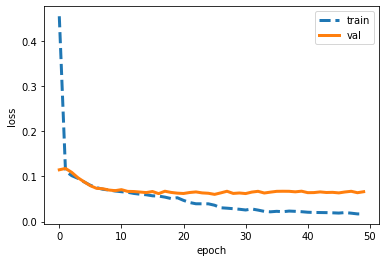

In [151]:
plot_loss(history.history)

In [153]:
model.evaluate(test_datagen, steps=test_datagen.samples // 64)

62/62 [==============================] - 3s 41ms/step - loss: 0.0649


0.0649416446685791

As we can see to get better results only a deeper network is not enough. Let's stop on the model **model_3cnn_2dense.h5**.

# Test

Load the model and get predictions for unlabeled data.

In [12]:
model = load_model(os.path.join(MODELS_PATH, 'model_3cnn_2dense.h5'))

In [13]:
predicted = model.predict(predict_datagen, verbose=1, steps=1001)

1001/1001 [==============================] - 5s 5ms/step


Transform the resulting predictions into a DataFrame with a structure similar to train.csv.

In [ ]:
rows = []
for file, points in zip(predict_datagen.filenames, predicted):
    image = cv2.imread(os.path.join('test_data', file))
    # x multiplier
    scale_x = image.shape[1]/2
    # y multiplier
    scale_y = image.shape[0]/2
    # translate the points to the coordinates of the original image
    points[0::2] = points[0::2]*scale_x + scale_x
    points[1::2] = points[1::2]*scale_y + scale_y
    # add row
    row = [os.path.basename(file)]
    row.extend(points.astype(int).tolist())
    rows.append(row)
columns = ['filename']
for i in range(1, 15):
    columns.append(f'x{i}')
    columns.append(f'y{i}')
submission = pd.DataFrame(rows, columns=columns)

In [ ]:
submission = pd.DataFrame(predict_datagen.filenames, columns=['filename'])
xy = pd.DataFrame(predicted, columns=data_df.columns.drop('filename'))
submission = pd.concat((submission, xy))

In [16]:
submission.head(10)

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00008.jpg,19,16,34,16,50,17,64,19,22,23,28,24,33,23,50,25,55,25,61,26,40,41,28,55,39,56,50,56
1,00014.jpg,162,28,117,44,66,61,14,79,157,48,139,54,123,64,69,84,49,87,30,97,124,120,162,146,134,158,95,170
2,00015.jpg,109,62,135,58,159,60,171,64,111,82,122,83,128,82,151,85,158,83,165,86,141,136,111,178,132,181,143,180
3,00017.jpg,75,120,137,100,222,85,303,71,104,149,126,141,152,136,236,125,262,116,295,111,198,212,173,294,221,286,278,276
4,00023.jpg,1216,444,1006,446,792,468,568,513,1161,579,1088,580,1016,593,783,635,697,629,617,638,952,972,1091,1216,952,1263,797,1254
5,00029.jpg,322,295,344,241,356,199,368,157,296,292,305,268,311,264,328,213,340,194,330,185,250,264,191,322,204,290,219,257
6,00031.jpg,82,26,69,27,55,30,40,34,80,39,75,38,71,40,56,44,50,44,45,46,70,70,80,91,72,94,61,95
7,00033.jpg,1227,657,1078,508,913,347,745,185,1129,715,1048,662,993,611,810,443,766,370,698,335,743,778,692,1063,573,971,464,846
8,00037.jpg,16,34,32,27,53,21,74,15,24,42,30,38,37,37,58,32,65,29,74,27,50,55,46,77,58,74,73,70
9,00044.jpg,211,83,183,76,149,69,111,64,199,106,189,99,175,102,142,95,130,89,115,88,151,157,159,200,137,202,117,190


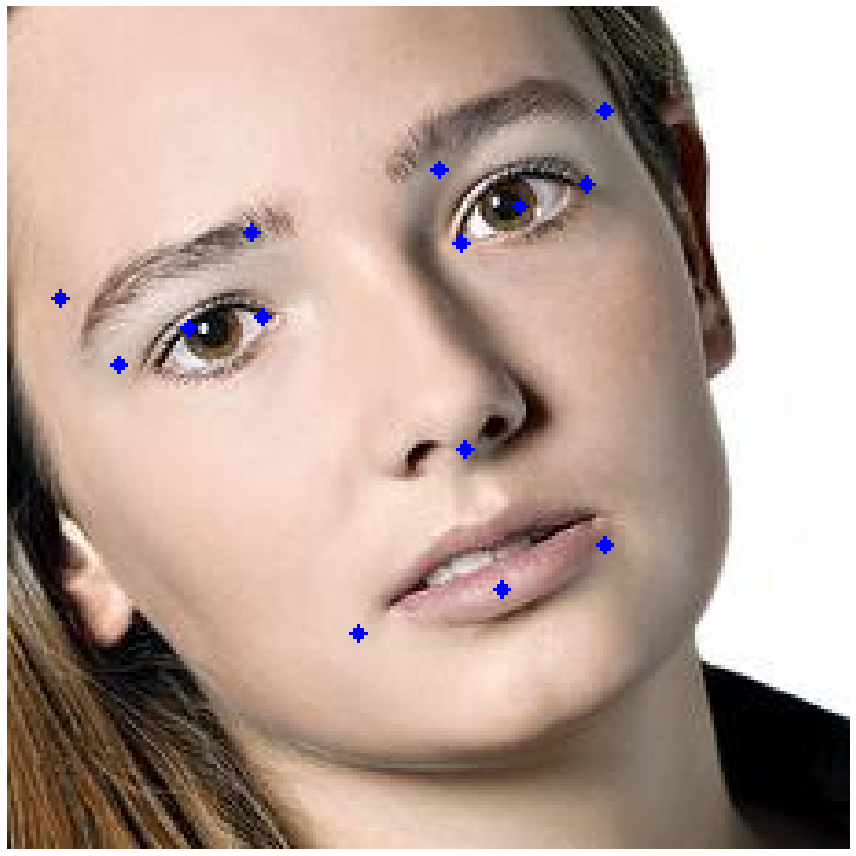

In [23]:
image = cv2.imread(os.path.join('test_data/test', submission['filename'].iloc[1]))
points = points_to_list(submission.iloc[1].drop('filename').values)
show_image(image, points)

As we can see on the image, some points are quite close to the real ones, but some are displaced.

In [ ]:
submission.to_csv('submission.csv')